In the exercise I reviewed the article: Balasooriya, S., Munasinghe, H., Herath, A.T. et al. Possible links between groundwater geochemistry and chronic kidney disease of unknown etiology (CKDu): an investigation from the Ginnoruwa region in Sri Lanka. Expo Health (2019). doi.org/10.1007/s12403-019-00340-w. I focused on the causal mechanism of hydrochemical profile of wells water in Ginnoruwa region (dry zone of Sri Lanka) and kidney disease of unknown etiology (CKDu). I simulate artificial dataset with 10000 samples for both, non CKDu (NO) and CKDu wells.

import libraries

In [1]:
import pandas as pd
import numpy as np
import uuid
import matplotlib.pyplot as plt
import scipy.interpolate as intrp
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

As you can see in Table 1 and Table 2, we have information about the following statistics: mean, median, sd, min, max, median, 25 and 75 quartiles. As shown in the paper, the data are not normally distributed. So I decided to generate a dataset based on the min, q25, median, q75 and max values. It can be said that the minimum and maximum values can be outliers, but we do not have much information about the causality of their occurrence (natural process or bad measurements). The article says: Extremely low EC values in some wells may be related to the admixture of rapidly absorbed rainwater or mixing with water drawn from small reservoirs near the wells. But I don't know how often that can happen. This is the reason, why I simulated the data between min/q25 and q75/max. Data generated in this way also follows the mean of the original data and have different sd.

In [2]:
# function for generate data based on quartiles
def data_generator(column_name: str,minimum: float ,q25: float ,median: float, q75: float ,maximum: float, set_size: int):
    #interpolate data
    interp=intrp.interp1d([0, 0.25, 0.5, 0.75, 1],[minimum,q25,median,q75,maximum])
    # random data generator
    values = interp (np.random.random(size=set_size))
    df = pd.DataFrame(data=values).rename(columns={0: column_name})
    return df

In [3]:
# function for generating data based on our tables
def calculator(data: pd.DataFrame, set_size: int):
    # feature name
    lst = []
    for col in data:
        column_name = col
        v = data[column_name].to_frame()
        
        # rows which define quartile borders
        for index in range(v.shape[1]):
            columnSeriesObj = v.iloc[: , index]
        
            minimum = columnSeriesObj.values[0]
            maximum = columnSeriesObj.values[1]
            q25 = columnSeriesObj.values[2] 
            median = columnSeriesObj.values[3] 
            q75 = columnSeriesObj.values[4]

            # generate data 
            set_size = set_size
            vysledok = data_generator(column_name,minimum,q25,median,q75,maximum,set_size)
            lst.append(vysledok)
    
    # transform to df
    np_array = np.asarray(lst)
    fin_arr = np_array.reshape(15,set_size)
    dff = pd.DataFrame(fin_arr).T
    table = pd.DataFrame(data=dff.values, columns=data.columns)
    
    return table

### Table 1 - major element compositions - generate artificial data and statistical test

In [4]:
# NOrmal CDku wells
data_NO = pd.read_excel(r'C:\Users\dg\Desktop\viares\4modul\tab1.xlsx', index_col = 0, sheet_name ='NO').T
# CDKu wells
data_CDKu = pd.read_excel(r'C:\Users\dg\Desktop\viares\4modul\tab1.xlsx', index_col = 0, sheet_name ='CDKu').T

In [5]:
# apply data generator function for 10000 sets
final_NO = calculator(data_NO,10000)
final_CDKu = calculator(data_CDKu,10000)

In [6]:
# function for callcuation mean and sd of dataset
def mean_sd(artif_data: pd.DataFrame, sample_name: str):
    mean = artif_data.mean().to_frame().rename(columns={0: sample_name})
    sd = artif_data.std().to_frame().rename(columns={0: sample_name})
    
    return mean, sd

In [7]:
# calculate mean and sd for both sets
NO_wells = mean_sd(final_NO, 'NO') 
CDKu_wells = mean_sd(final_CDKu, 'CDKu')

# join NO and CDKu data together
means = NO_wells[0].join(CDKu_wells[0])
sds = NO_wells[1].join(CDKu_wells[1])

<AxesSubplot:xlabel='Feature', ylabel='Mean (log)'>

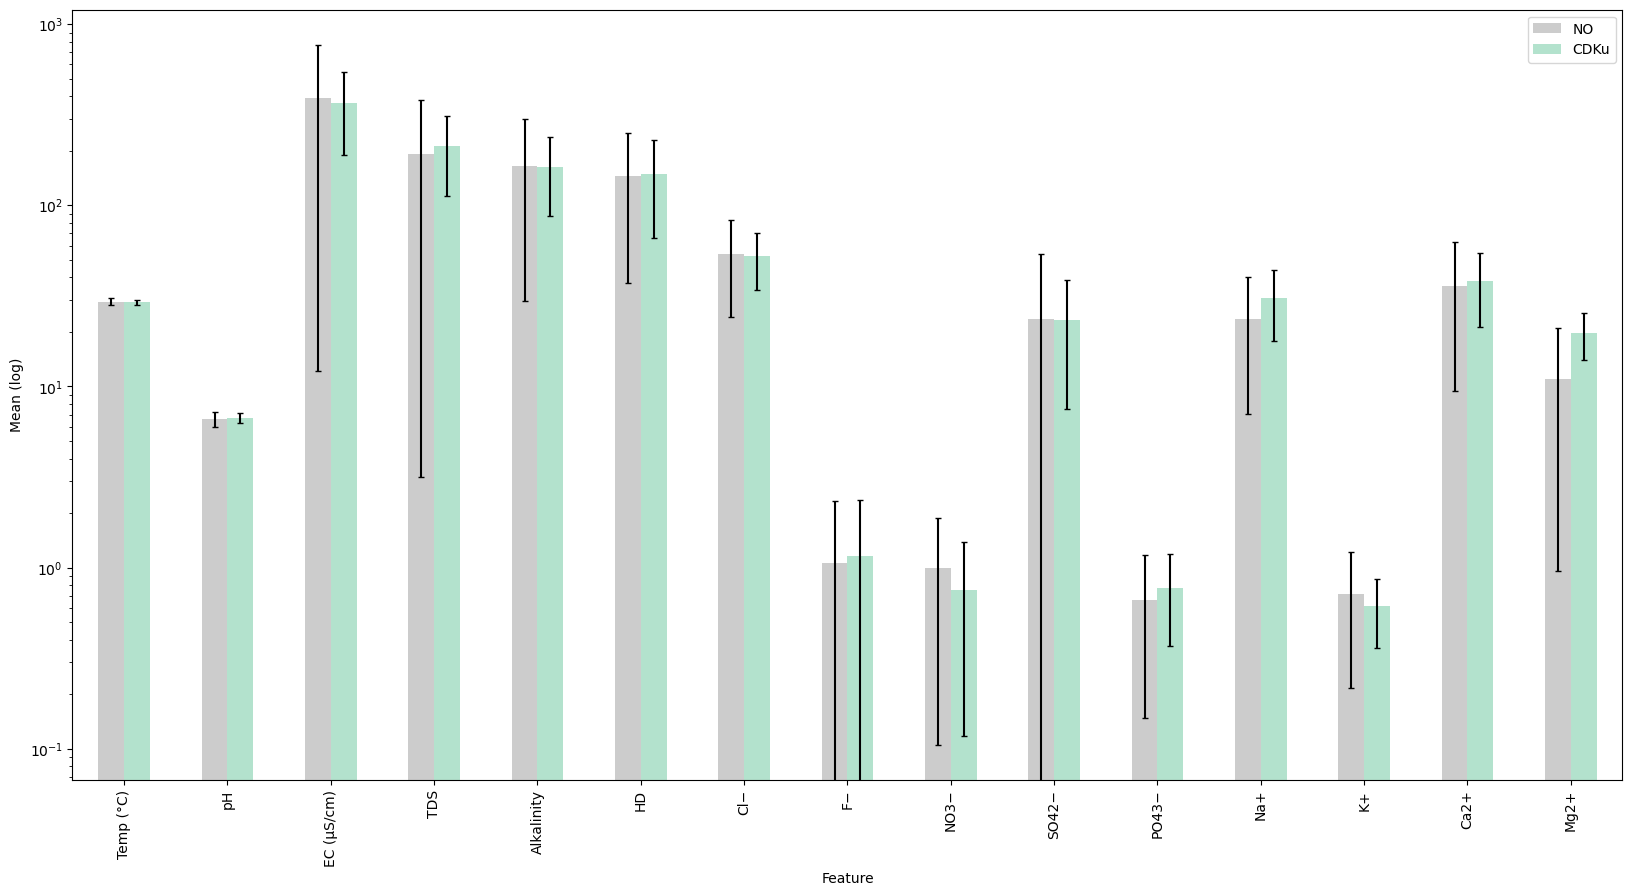

In [8]:
# plot results
fig, ax = plt.subplots()
plt.ylabel('Mean (log)')
plt.xlabel('Feature')
means.plot(yerr=sds,ax=ax, kind='bar', log=True,capsize=2, colormap='Pastel2_r', figsize=(20, 10))

The figure shows categorical histogram in major element composition of no/CDKu wells. In the article is: Lower alkalinity and hardness values were observed in non-CKDu wells when compared to those of CKDu wells. In my data alkalinity and hardness are relatively same for non-CKDu and CKDu wells.

They said: Overall, mean levels of pH, EC/TDS, HD, alkalinity, F−, Ca2+, and Mg2+ were higher in CKDu wells when compared to their non-CKDu counter parts. In my artificial data is pH level relatively same for both groups. EC is higher in non-CKDu wells and TDS is higher in CKDu wells. F-, Ca2+ and Mg+ are higher in article data which is also true for my dataset. 

In paper is mentioned: However, all trace element levels were well below the drinking water limits defned by the World Health Organization (WHO 2011).

#### statistical significance - Mann Whithey U test (two-tailed). Significance level of 0.05 like in the paper. The null hypothesis is: measurments from non cdku and cdku wells comes from same population (they are same).

In [9]:
# def function for transforming artificial data to list format
def rsp_lst(artif_set: pd.DataFrame):
    
    lst = []
    for (colname,colval) in artif_set.iteritems():
        x = [colval.values]
        my_array = np.array(x).reshape(10000)
        lst.append(my_array)
    return lst

In [10]:
# transform
NO_list = rsp_lst(final_NO)
CDKu_list = rsp_lst(final_CDKu)

In [11]:
def mannwhitney(NO_list: list, CDKu_list: list, NO_artif: pd.DataFrame, CDKu_artif: pd.DataFrame):
    
# calculate mannwhitney p value
    final = []
    for x in NO_list:
        for y in CDKu_list:
            xx = stats.mannwhitneyu(x,y,alternative = 'two-sided')
            final.append(xx)
            
# generate possible feature names combinations 
    names_NO = NO_artif.columns.values.tolist()
    names_CDKu = CDKu_artif.columns.values.tolist()

    final_name = []
    for x in names_NO:
        for y in names_CDKu:
            z = x,y
            final_name.append(z)
        
# join feature names with mann whitney stats
    df_name = pd.DataFrame(final_name)
    df_mannwhitney = pd.DataFrame(final)
    stats_mannwhite = df_name.join(df_mannwhitney)

# only same feature between sets
    fin_stat = stats_mannwhite[stats_mannwhite[0] == stats_mannwhite[1]]
    
    return fin_stat

In [12]:
fin_stat = mannwhitney(NO_list, CDKu_list, final_NO, final_CDKu)

In [13]:
# bold significant p values in final df
def highlight(x):
    return 'font-weight: bold' if x < 0.05 else ''

In [14]:
fin_stat.reset_index(drop = True).style.applymap(highlight, subset= 'pvalue')

,0,1,statistic,pvalue
0,Temp (°C),Temp (°C),53841259.000000,0.000000
1,pH,pH,45603050.000000,0.000000
2,EC (μS/cm),EC (μS/cm),40422435.000000,0.000000
3,TDS,TDS,34779546.000000,0.000000
4,Alkalinity,Alkalinity,41264939.000000,0.000000
5,HD,HD,44695086.000000,0.000000
6,Cl−,Cl−,46049752.000000,0.000000
7,F−,F−,38432145.000000,0.000000
8,NO3−,NO3−,58104002.000000,0.000000
9,SO42−,SO42−,34019585.000000,0.000000


Only for K+ we can't reject null hypothesis. For all others features we can say they come from two different populations (types of wells here).

### Table2 element composition of groundwater - generate artificial data and statistical test

In [15]:
# NOrmal CDku wells
data_NO_CH = pd.read_excel(r'C:\Users\dg\Desktop\viares\4modul\tab2.xlsx', index_col = 0, sheet_name ='NO').T
# CDKu wells
data_CDKu_CH = pd.read_excel(r'C:\Users\dg\Desktop\viares\4modul\tab2.xlsx', index_col = 0, sheet_name ='CDKu').T

In [16]:
final_NO_CH = calculator(data_NO_CH,10000)
final_CDKu_CH = calculator(data_CDKu_CH,10000)

In [17]:
# calculate mean and sd
NO_wells_CH = mean_sd(final_NO_CH, 'NO') 
CDKu_wells_CH = mean_sd(final_CDKu_CH, 'CDKu')

# join NO and CDKu data together
means_CH = NO_wells_CH[0].join(CDKu_wells_CH[0])
sds_CH = NO_wells_CH[1].join(CDKu_wells_CH[1])

<AxesSubplot:xlabel='Feature', ylabel='Mean (log)'>

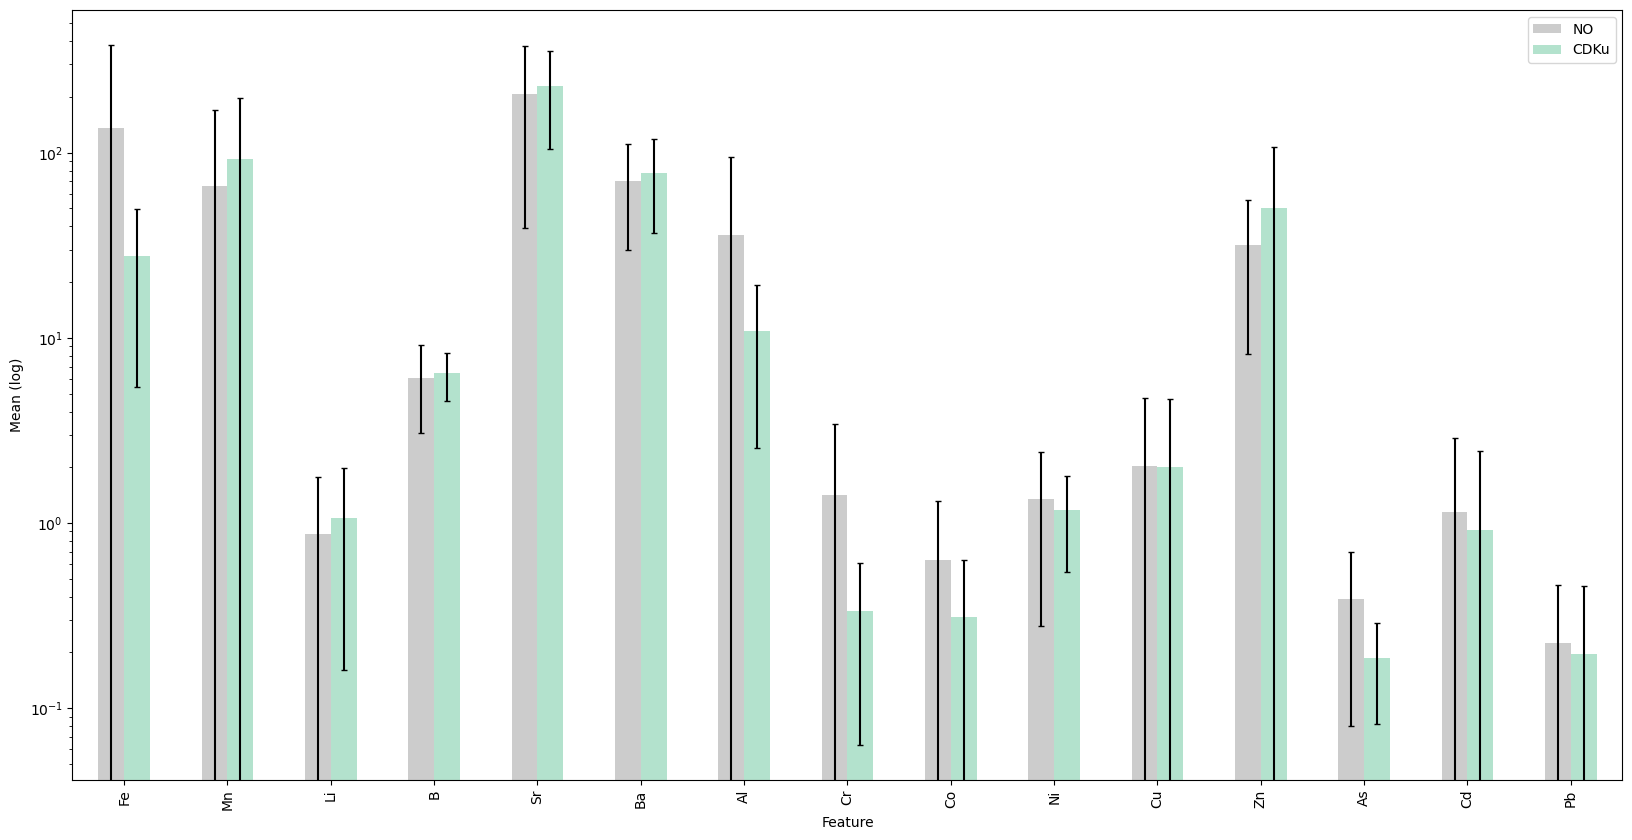

In [18]:
# plot results
fig, ax = plt.subplots()
plt.ylabel('Mean (log)')
plt.xlabel('Feature')
means_CH.plot(yerr=sds_CH,ax=ax, kind='bar', log=True,capsize=2, colormap='Pastel2_r', figsize=(20, 10))

For articel data: the mean Sr2+ and Ba2+ contents were higher in CKDu wells 2. In addition, mean contents of total dissolved 
Fe2+ and Mn2+ were higher in non-CKDu wells when compared to CKDu wells. In my data is Sr2+, Ba2+ is also higher in CKDu wells but. Fe is higher in Non-CKDu wells like in the paper but Mn mean is higher in CKDu wells which is in contrasnt with article data.

In [19]:
# transform
NO_list_CH = rsp_lst(final_NO_CH)
CDKu_list_CH = rsp_lst(final_CDKu_CH)

In [20]:
# calculating mannwhitney two tailed test
fin_stat_CH = mannwhitney(NO_list_CH, CDKu_list_CH, final_NO_CH, final_CDKu_CH)

In [21]:
# bolt significant p values
fin_stat_CH.reset_index(drop = True).style.applymap(highlight, subset= 'pvalue')

,0,1,statistic,pvalue
0,Fe,Fe,48874815.000000,0.005850
1,Mn,Mn,38226101.000000,0.000000
2,Li,Li,39232531.000000,0.000000
3,B,B,47470068.000000,0.000000
4,Sr,Sr,39821505.000000,0.000000
5,Ba,Ba,44157437.000000,0.000000
6,Al,Al,52124495.000000,0.000000
7,Cr,Cr,71615847.000000,0.000000
8,Co,Co,67604532.000000,0.000000
9,Ni,Ni,49825847.000000,0.669690


As you can see for every feature expect Ni and Cu is the null hypothesis rejected. Which means there are significant differencies between measured chemical components between non and CDKu wells.

In the paper researchers found statistically signifcant diferences between non-CKDu and CKDu wells only in 
in parameters TDS or EC (p=0.016), SO4 2− (p=0.005), PO4 3− (p=0.030), F− (p=0.048); Na+ (p=0.008) and Mg2+ (p=0.008).

# correlation between features in CDKu wells

Researchers mentioned there is correlation of fluoride contents in all groundwater samples with alkalinity (r2= + 0.709), Na+ (r2= +0.663), Mg2+ (r2=0.610), Ca2+ (r2= +0.510), and Sr2+ (r2 = + 0.533). Which might indicate possible exchanges of Ca2+ and Sr2+ for Na+.

In [22]:
# join 2 artificial sets for CDKu wells
CDku_meas =  final_CDKu.join(final_CDKu_CH)
# feature correlations
corr = CDku_meas.corr()
# only upper triangle
mask_corr = np.triu(corr)

In [23]:
# lets try to find only correlation higher than 0.5
corrf = corr > 0.5
stackk = corrf.stack()

In [24]:
# Count True values = correlated featurs. We need to substract autocorrelation
fincor =  stackk.value_counts() - 30
# Finnal number of True values represent number of correlated features
fincor

False    840
True       0
dtype: int64

As you can see (0 True values) I didn't found any correlation between features in non CDKu wells and CDKu wells.

I think there are other interesting things. CDKu in the Ginnoruwa region is more prevalent in the male population (3:1). Is there a causal mechanism specific to the male population? Or are there just more men in the population? Second, it may be interesting to measure the hydrochemical profile of groundwater systematically at different depths and in different seasons.